**Numerical Features (10)**

1. **Administrative** - Count of administrative pages visited
2. **Administrative_Duration** - Time spent on administrative pages
3. **Informational** - Count of informational pages visited
4. **Informational_Duration** - Time spent on informational pages
5. **ProductRelated** - Count of product-related pages visited
6. **ProductRelated_Duration** - Time spent on product-related pages
7. **BounceRates** - Percentage of visitors who enter and leave without interaction
8. **ExitRates** - Percentage of pageviews that were the last in the session
9. **PageValues** - Average value for web pages before completing e-commerce transaction
10. **SpecialDay** - Closeness to special days

**Categorical Features (7)**

1. **Operating System** - Visitor's operating system
2. **Browser** - Web browser used
3. **Region** - Geographical region of visitor
4. **Traffic Type** - Traffic source type
5. **Visitor Type** - New or returning visitor
6. **Weekend** - Weekend visit indicator
7. **Month** - Month of session occurrence

**Target Variable**

* **Revenue** - Session outcome indicator
    * `True`: Session ended with shopping transaction
    * `False`: Session did not end with shopping transaction

In [119]:
#Importing Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import os

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")


In [90]:
df = pd.read_csv("online_shoppers_intention.csv")

In [91]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [92]:
missing = df.isnull().sum()
print(missing)

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [93]:
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Found {duplicates} duplicate rows ({duplicates/len(df)*100:.2f}% of data)")
else:
    print("No duplicate rows found!")

Found 125 duplicate rows (1.01% of data)


In [94]:
df = df.drop_duplicates().reset_index(drop=True)
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


In [95]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12205 entries, 0 to 12204
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12205 non-null  int64  
 1   Administrative_Duration  12205 non-null  float64
 2   Informational            12205 non-null  int64  
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  int64  
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  int64  
 12  Browser                  12205 non-null  int64  
 13  Region                   12205 non-null  int64  
 14  TrafficType           

In [96]:
#Number of rows and columns within the dataset
df.shape


(12205, 18)

**Target Variable**

* **Revenue** 
    * `True`: User bought something.
    * `False`: User bought nothing.


In [97]:
target_counts = df['Revenue'].value_counts()


print("Revenue Distribution:")
print("=" * 45)
print(f"FALSE (No Purchase): {target_counts[False]:,} ({(target_counts[False] /((target_counts[False]+target_counts[True])))*100:.2f}%)")
print(f"TRUE (Purchase):     {target_counts[True]:,} ({(target_counts[True] / (target_counts[True]+target_counts[False]))*100:.2f}%)")


Revenue Distribution:
FALSE (No Purchase): 10,297 (84.37%)
TRUE (Purchase):     1,908 (15.63%)


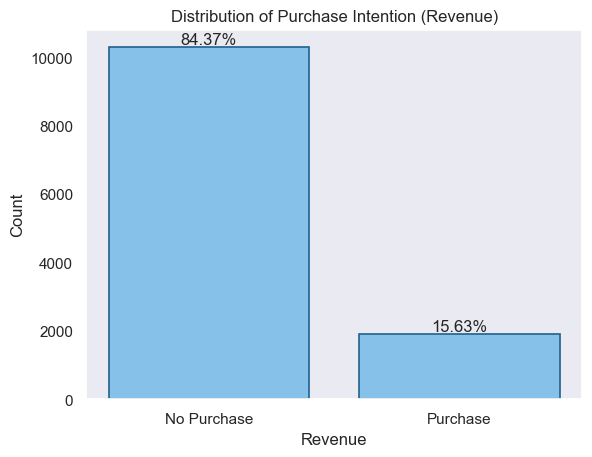

In [98]:
percentages=[f"{(target_counts[False] /((target_counts[False]+target_counts[True])))*100:.2f}%",f"{(target_counts[True] /((target_counts[False]+target_counts[True])))*100:.2f}%"]

bars=plt.bar(["No Purchase","Purchase"],target_counts,color="#85C1E9",edgecolor="#21618C",linewidth=1.2)

plt.bar_label(bars, labels=percentages,label_type='edge')
plt.ylabel("Count")
plt.xlabel("Revenue")
plt.title("Distribution of Purchase Intention (Revenue)")
plt.grid(False)
plt.show()

**Category Data**


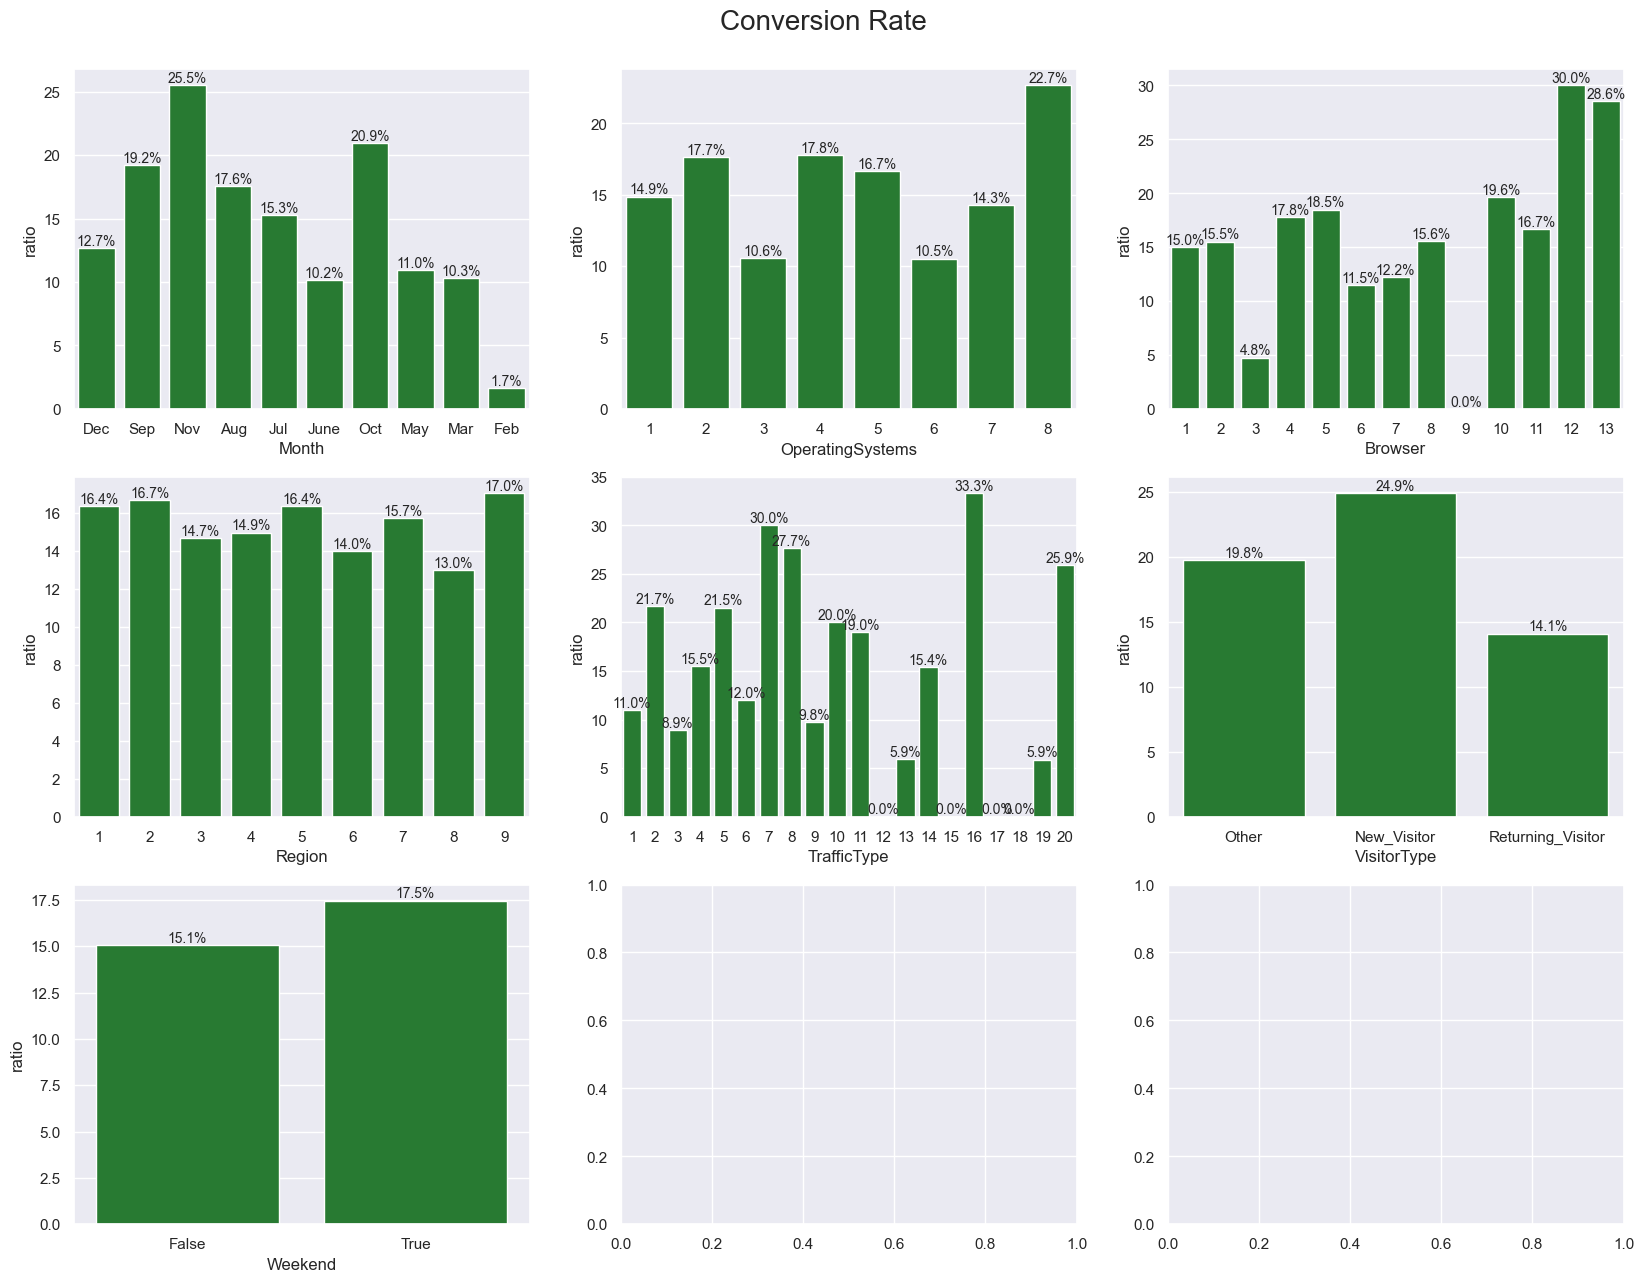

In [99]:
# sns.set(rc={"axes.facecolor":"#E7F8E6","figure.facecolor":"#E7F8E6"})
# cmap = colors.ListedColormap(["#094F29","#0A6921","#1A8828","#429B46","#64AD62","#94C58C"])

cat_columns = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20,15))

counter = 0

#Plotting Conversion Rate for each feature
for cat_column in cat_columns:
    df_count = pd.DataFrame(columns=[cat_column, 'ratio'])

    for t in df[cat_column].unique():
        value = df[cat_column][df[cat_column]==t][df['Revenue']==True].count()/df[cat_column][df[cat_column]==t].count()*100
        df_count = pd.concat([pd.DataFrame([[t,value]], columns=df_count.columns), df_count], ignore_index=True)
    
    fig_x = counter // 3
    fig_y = counter % 3
    sns.barplot(data=df_count, x=cat_column, y='ratio', ax=axs[fig_x, fig_y], color='#1A8828')
    axs[fig_x, fig_y].bar_label(axs[fig_x, fig_y].containers[0], fmt=lambda x: f'{x:0.1f}%', fontsize=10);

    counter += 1

fig.suptitle("Conversion Rate", fontsize=20, y=0.92)

plt.show()

In [100]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000
mean,2.338878,81.646331,0.508726,34.825454,32.045637,1206.982457,0.020370,0.041466,5.949574,0.061942,2.124211,2.357804,3.153298,4.073904
std,3.330436,177.491845,1.275617,141.424807,44.593649,1919.601400,0.045255,0.046163,18.653671,0.199666,0.906823,1.710114,2.402340,4.016654
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,193.000000,0.000000,0.014231,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,9.000000,0.000000,0.000000,18.000000,608.942857,0.002899,0.025000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,94.700000,0.000000,0.000000,38.000000,1477.154762,0.016667,0.048529,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


**numerical columns**

In [101]:
print("Statistical Summary of Numerical Features:")
print("=" * 80)
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 
                      'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                      'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
df[numerical_features].describe()

Statistical Summary of Numerical Features:


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000
mean,2.338878,81.646331,0.508726,34.825454,32.045637,1206.982457,0.020370,0.041466,5.949574,0.061942
std,3.330436,177.491845,1.275617,141.424807,44.593649,1919.601400,0.045255,0.046163,18.653671,0.199666
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,193.000000,0.000000,0.014231,0.000000,0.000000
50%,1.000000,9.000000,0.000000,0.000000,18.000000,608.942857,0.002899,0.025000,0.000000,0.000000
75%,4.000000,94.700000,0.000000,0.000000,38.000000,1477.154762,0.016667,0.048529,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


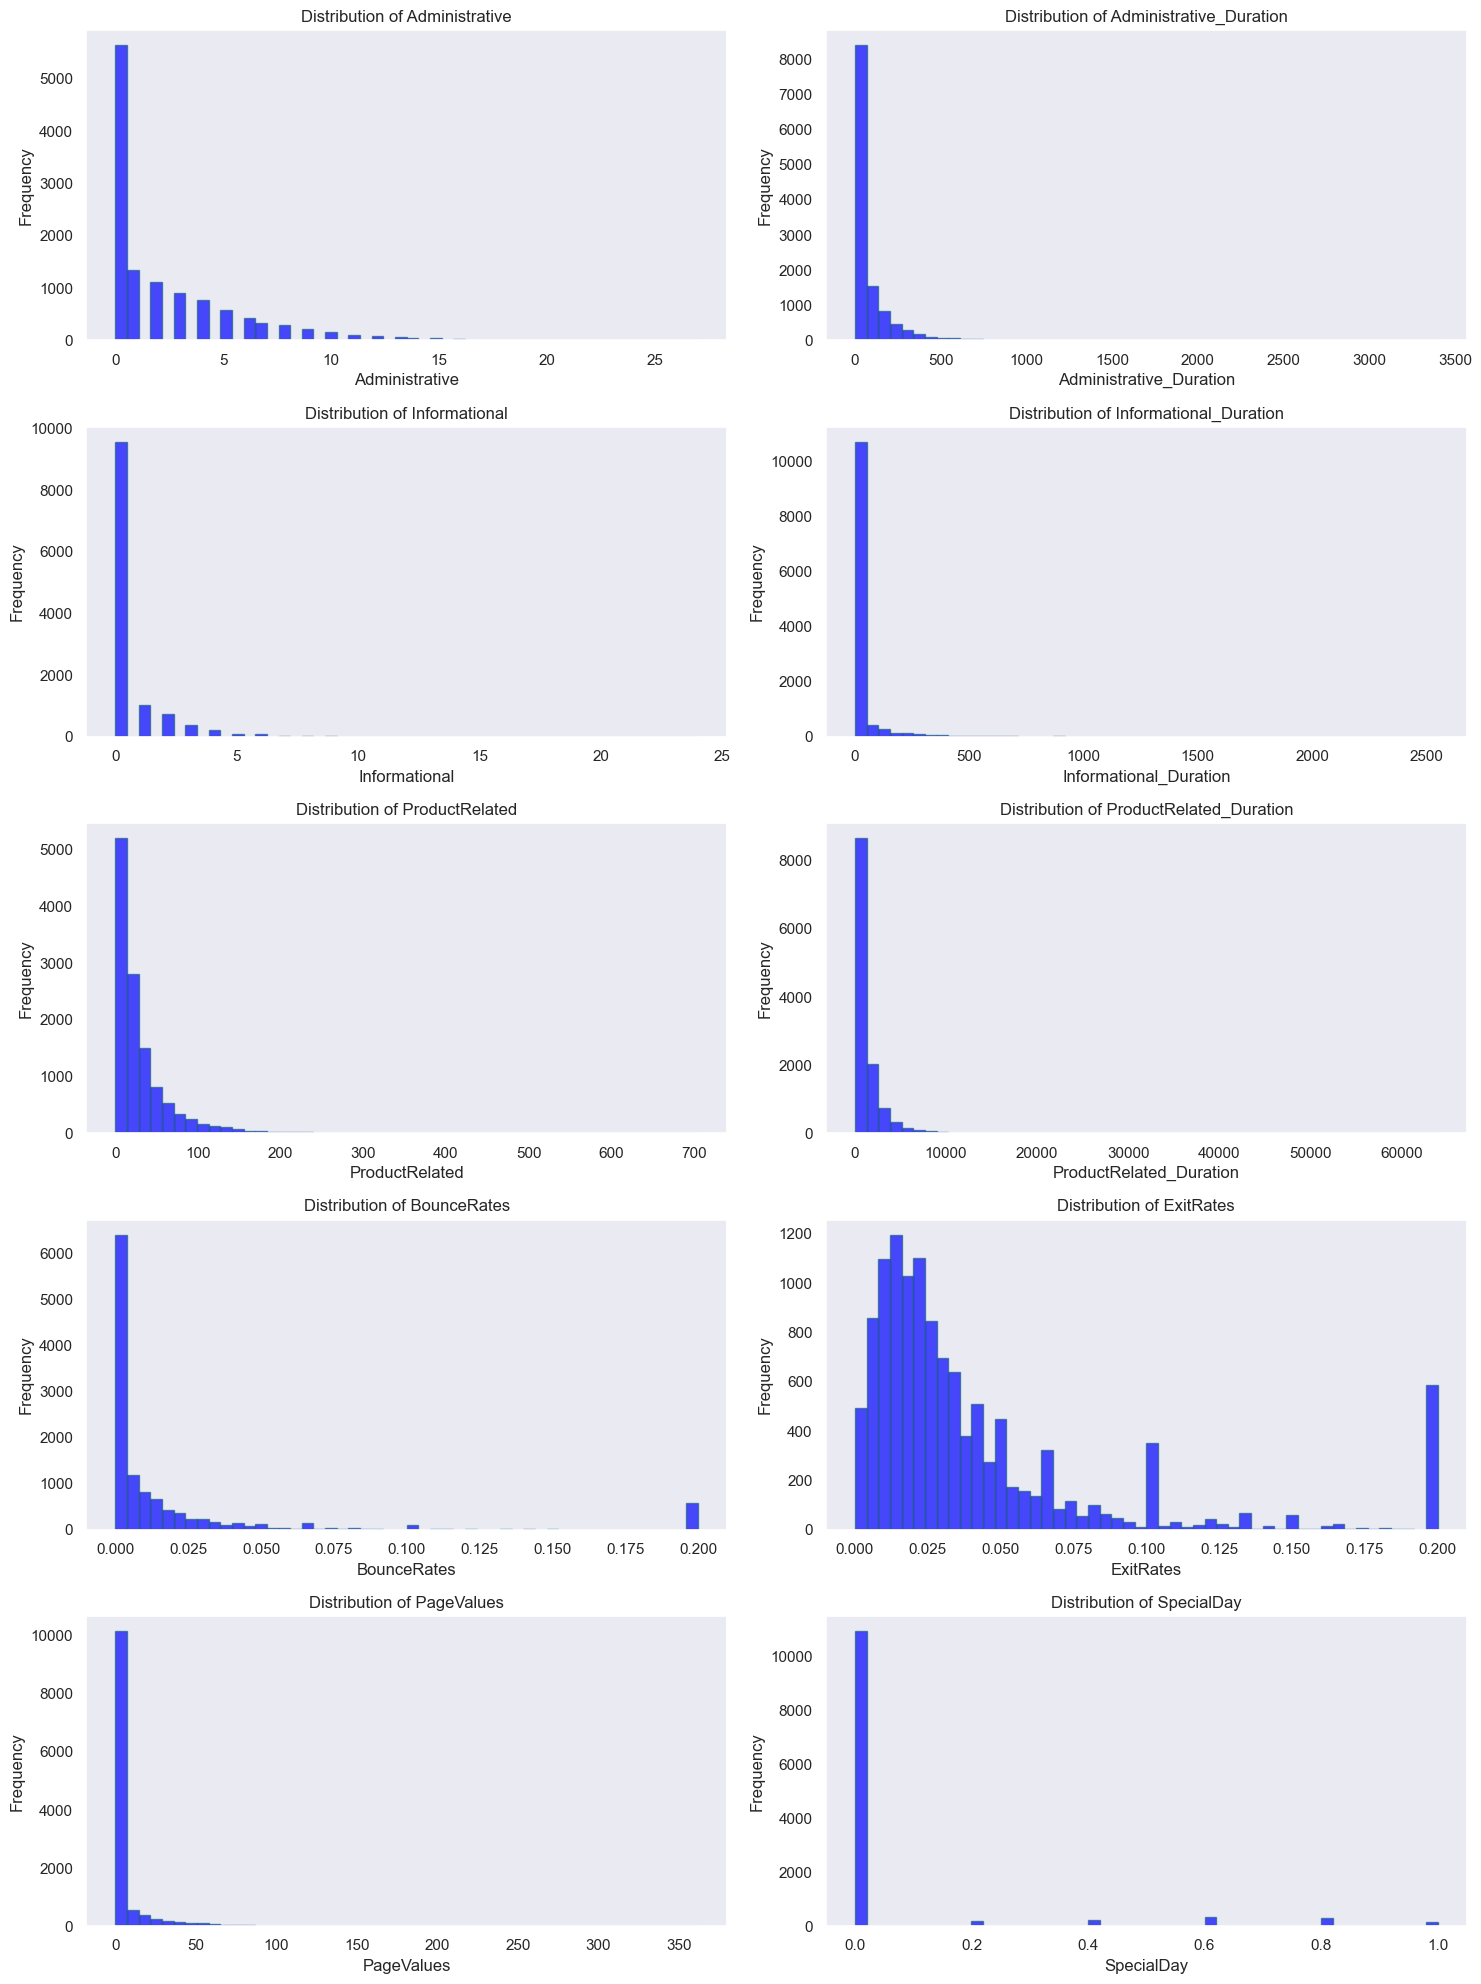

In [102]:
# Visualize Distribution of numerical features
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    axes[idx].hist(df[col], bins=50, color='blue', edgecolor='#21618C', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

Most features (like ProductRelated and Administrative_Duration) are skewed to the right. This means most users browse very few pages for a short time


Correlation with Revenue:
Revenue                    1.000000
PageValues                 0.491894
ProductRelated             0.156042
ProductRelated_Duration    0.150077
Administrative             0.136330
Informational              0.093626
Administrative_Duration    0.091768
Informational_Duration     0.069358
SpecialDay                -0.083601
BounceRates               -0.145091
ExitRates                 -0.204320
Name: Revenue, dtype: float64


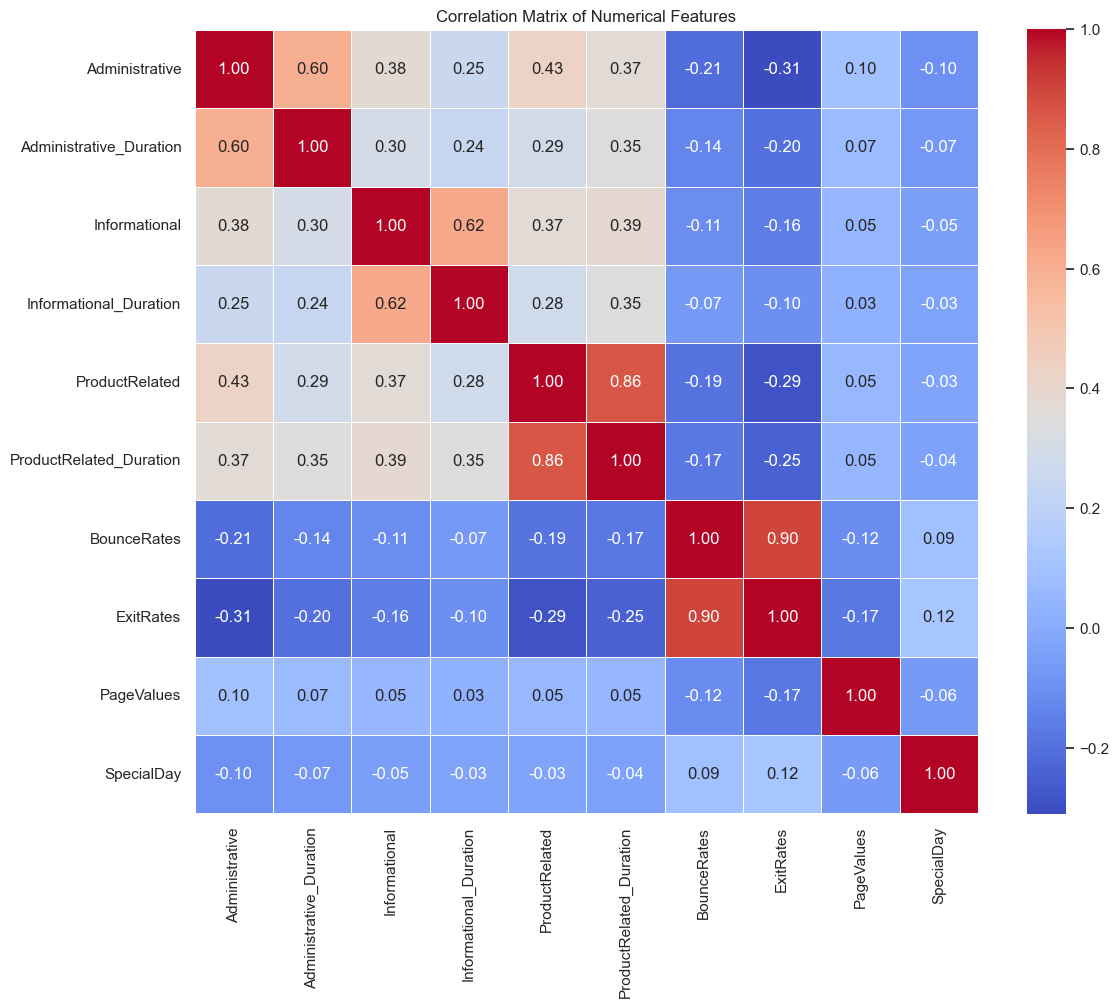

In [103]:
# Correlation Analysis

print("\nCorrelation with Revenue:")
print("=" * 50)
correlation_with_target = df[numerical_features + ['Revenue']].corr()['Revenue'].sort_values(ascending=False)
print(correlation_with_target)


plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            linewidths=0.5, square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

**Data Preprocessing**

In [104]:
df_encoded = df.copy()
label_encoder = LabelEncoder()

# Encode Month 
month_order = {'Feb': 1, 'Mar': 2, 'May': 3, 'June': 4, 'Jul': 5, 
               'Aug': 6, 'Sep': 7, 'Oct': 8, 'Nov': 9, 'Dec': 10}
df_encoded['Month'] = df_encoded['Month'].map(month_order)

In [105]:
# VisitorType
df_encoded['VisitorType'] = label_encoder.fit_transform(df_encoded['VisitorType'])

In [106]:
# Weekend & Revenue
df_encoded['Weekend'] = df_encoded['Weekend'].astype(int)
df_encoded['Revenue'] = df_encoded['Revenue'].astype(int)

In [107]:
X = df_encoded.drop('Revenue', axis=1)
y = df_encoded['Revenue']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 9764 (80.0%)
Test set size: 2441 (20.0%)

Training set class distribution:
Revenue
0    8238
1    1526
Name: count, dtype: int64

Test set class distribution:
Revenue
0    2059
1     382
Name: count, dtype: int64


**Logistic Regression**

In [109]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Scaled training set shape: (9764, 17)
Scaled test set shape: (2441, 17)


### Class Distribution Analysis (Training Set)

The training set exhibits a significant **class imbalance** in the target variable (`Revenue`):

* **Class 0 (False / No Purchase):** 8,238 samples (~84.4%)
* **Class 1 (True / Purchase):** 1,526 samples (~15.6%)

**The Gap:**
There is a substantial gap between the classes, with a ratio of approximately **5.4:1**. Training a model on this data directly creates a bias towards the majority class (No Purchase), causing the model to perform poorly on identifying actual buyers.

**The Solution:**
To resolve this, we will apply **SMOTE **.  create a balanced training set.

In [115]:
# Oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"Oversampled training set shape: {X_train_smote.shape}")
print(f"Oversampled training set class distribution:\n{y_train_smote.value_counts()}")

Oversampled training set shape: (16476, 17)
Oversampled training set class distribution:
Revenue
1    8238
0    8238
Name: count, dtype: int64


In [124]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [125]:
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Model': model
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


Training Logistic Regression...
Logistic Regression - Accuracy: 0.8865, F1-Score: 0.5166, ROC-AUC: 0.8963

Training Decision Tree...
Decision Tree - Accuracy: 0.8591, F1-Score: 0.5509, ROC-AUC: 0.7342

Training Random Forest...
Random Forest - Accuracy: 0.9095, F1-Score: 0.6764, ROC-AUC: 0.9255

Training XGBoost...
XGBoost - Accuracy: 0.8980, F1-Score: 0.6566, ROC-AUC: 0.9223



Model Performance Summary:
                     Accuracy Precision    Recall  F1-Score   ROC-AUC
Random Forest        0.909463  0.767442  0.604712  0.676428  0.925487
XGBoost              0.897993  0.693878  0.623037  0.656552  0.922299
Decision Tree        0.859074  0.549479  0.552356  0.550914  0.734167
Logistic Regression  0.886522  0.774869  0.387435  0.516579  0.896257


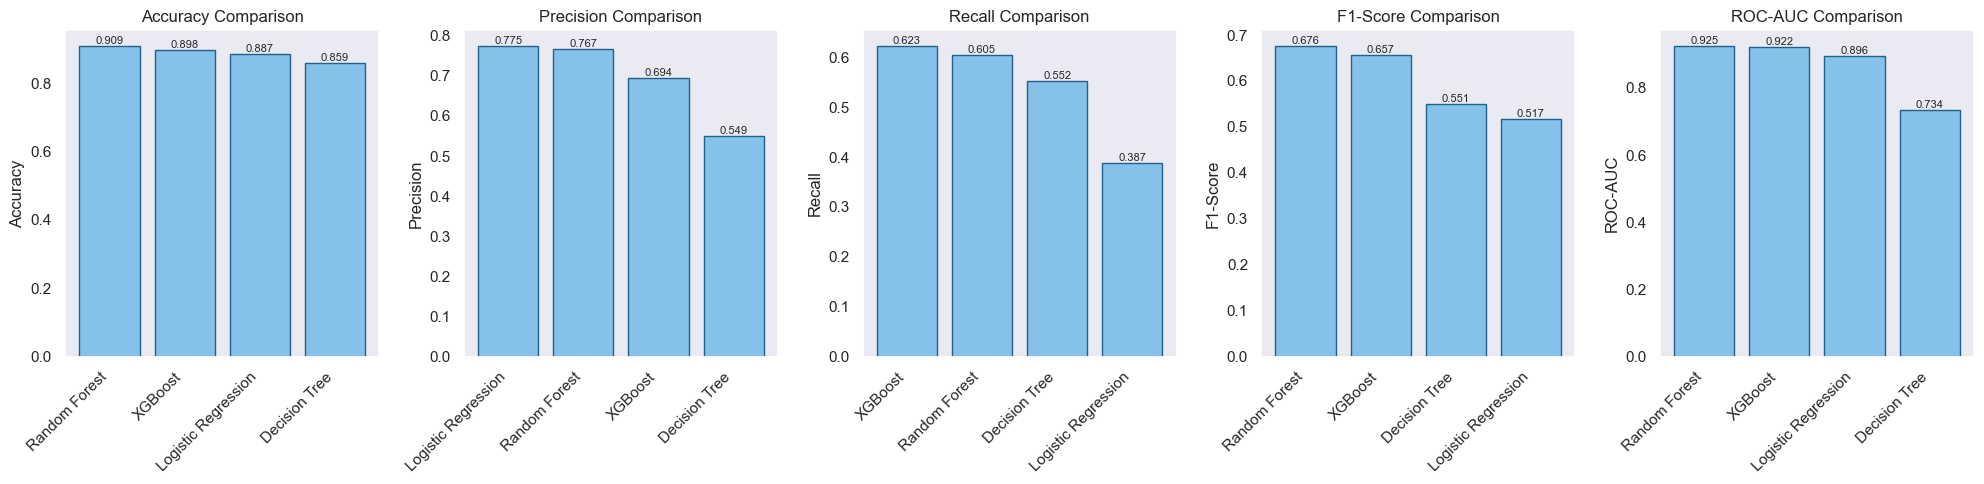

In [126]:
results_df = pd.DataFrame(results).T
results_df = results_df.drop('Model', axis=1)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\nModel Performance Summary:")
print(results_df)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))

for idx, metric in enumerate(metrics):
    sorted_results = results_df.sort_values(metric, ascending=False)
    bars = axes[idx].bar(range(len(sorted_results)), sorted_results[metric], 
                         color='#85C1E9', edgecolor='#21618C')
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xticks(range(len(sorted_results)))
    axes[idx].set_xticklabels(sorted_results.index, rotation=45, ha='right')
    axes[idx].grid(False)
    
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# # Feature Importance
# importances = xgb.feature_importances_
# feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
# print(feature_imp_df)

                    Feature  Gini Importance
8                PageValues         0.514889
10                    Month         0.090697
15              VisitorType         0.047047
6               BounceRates         0.043192
0            Administrative         0.030657
5   ProductRelated_Duration         0.028603
7                 ExitRates         0.027804
4            ProductRelated         0.027525
9                SpecialDay         0.023904
3    Informational_Duration         0.023717
1   Administrative_Duration         0.022836
14              TrafficType         0.022267
16                  Weekend         0.021303
11         OperatingSystems         0.020657
2             Informational         0.019633
13                   Region         0.017899
12                  Browser         0.017371


**associate rule**